In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf  # Statsmodels is a Python module for statistics

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF 
from statsmodels.stats.anova import anova_lm

from ISLP import load_data    # ISLP library for the book, it has built in functions and methods to build models 
from ISLP.models import (ModelSpec as MS, summarize , poly) # It also has built-in data that can be loaded

import matplotlib as mpl


#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'


sns.set(style="white") # Plot parameters defined globally
plt.style.use("seaborn-v0_8-white")

## 3.10 Multiple linear regression with the Carseats data

In [3]:
df_cs = load_data('Carseats')
df_cs.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [4]:
df_cs.isna().any() # no missing values

Sales          False
CompPrice      False
Income         False
Advertising    False
Population     False
Price          False
ShelveLoc      False
Age            False
Education      False
Urban          False
US             False
dtype: bool

In [5]:
df_cs.info() # 3 categorical attributes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    category
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    category
 10  US           400 non-null    category
dtypes: category(3), float64(1), int64(7)
memory usage: 26.7 KB


In [6]:
df_cs['Urban'].unique()

['Yes', 'No']
Categories (2, object): ['No', 'Yes']

In [7]:
df_cs['US'].unique()

['Yes', 'No']
Categories (2, object): ['No', 'Yes']

In [8]:
df_cs['ShelveLoc'].unique()

['Bad', 'Good', 'Medium']
Categories (3, object): ['Bad', 'Good', 'Medium']

### a)

In [10]:
y = df_cs['Sales']
X = MS(['Price', 'US', 'Urban']).fit_transform(df_cs) # built-in fit transform method automatically deals with categorical variables
                                                      # and adds a constant

X.head()

,intercept,Price,US[Yes],Urban[Yes]
0,1.0,120,1.0,1.0
1,1.0,83,1.0,1.0
2,1.0,80,1.0,1.0
3,1.0,97,1.0,1.0
4,1.0,128,0.0,1.0


In [11]:
MLR_CS_BL = sm.OLS(y,X) # Baseline Multiple linear regression model for the X train above 

MLR_CS_BL_res = MLR_CS_BL.fit()

print(MLR_CS_BL_res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           2.39e-23
Time:                        20:14:24   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.0435      0.651     20.036      0.0

In [12]:
MLR_CS_BL_res.conf_int() # confidence intervals of the model parameters

,0,1
intercept,11.763597,14.323341
Price,-0.064764,-0.044154
US[Yes],0.691304,1.709841
Urban[Yes],-0.555973,0.512141


In [ ]:
# Below is an easy way to use .ols() from statsmodel.formula.api. Easier to implement different predictors in a formula, 
# it also does not require adding a intercept to the X_train and also automatically deals with the categorical variables. 
# Erase the comment below to check  

# print(smf.ols(formula = "Sales ~ Price + Urban + US", data = df_cs).fit().summary())

### b) Price seems to have a negative effect on the Sales and since the p-value for its coefficient is vanishing, this relation is statistically significant. Similarly Sales of carseats sold in US are larger than carseats outside of US and this relation is statistically significant as indicated by the t-statistics and the corresponding small p-value. On average if store is located in US, it will sell app. 1201 more car seats as compared to a store outside the US. Urban coefficient is not statistically significant suggesting that there is not relationship between Urban and Sales.

### c) 

$$ \rm{Sales} = 13.0435 - 0.0545 \times \rm{Price} + 1.2006 \times \rm{US} - 0.0219 \times \rm{Urban}, \quad\quad \rm{Urban} = \{0,1\}, \quad  \rm{US} = \{0,1\} \$$

### d) Based on the p-values, we can reject the null hypothesis  $H_0 = \beta_0 = 0$ (i.e in the absence of Price, US and Urban average sales is non-zero), $H_0: \beta_{\rm Price} = 0$ and $H_0: \beta_{\rm US} = 0$. We can not reject $H_0: \beta_{\rm Urban} = 0$ as the p-value is very large.

### e) Now remove Urban and fit again 

In [17]:
print(smf.ols(formula = "Sales ~ Price + US", data = df_cs).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           2.66e-24
Time:                        20:30:41   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0308      0.631     20.652      0.0

### f) It is clear from comparing the $R^2$ statistics of both models that the larger model including Urban as a predictor is not superior, i.e the variance explained in the response is not increased at all by including an additional predictor.

### anova_lm() function compares the two models and re-phareses this statment in the form of F-statistics to reject the null hypothesis that Urban variable in the bigger model is not needed and the alternative hypothesis is the bigger model is superior. F-statistics is small and so that we can reject the null hypothesis that the Urban variable of the bigger model is not needed. 

In [21]:
results_small = smf.ols(formula = "Sales ~ Price + US", data = df_cs).fit()

results_large = smf.ols(formula = "Sales ~ Price + Urban + US", data = df_cs).fit()

anova_lm(results_small,results_large)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,397.0,2420.874462,0.0,NaN,NaN,NaN
1,396.0,2420.834671,1.0,0.03979,0.006509,0.935739


### g) 

In [22]:
vars = results_small.conf_int(alpha = 0.05, cols = None).index
for var in vars:
    print(f'95 Percent confidence interval for the {var} is {results_small.conf_int(alpha = 0.05, cols = None).loc[var].values}')

95 Percent confidence interval for the Intercept is [11.7903202  14.27126531]
95 Percent confidence interval for the US[T.Yes] is [0.69151957 1.70776632]
95 Percent confidence interval for the Price is [-0.06475984 -0.04419543]


### h)

In [23]:
stud_resid = results_small.get_influence().resid_studentized_internal

leverage = results_small.get_influence().hat_matrix_diag

In [24]:
# Cook's distance can be used to identify influential observations in a regression model. 
# Essentially Cook’s distance measures how much all of the fitted values in the model change when the ith observation is deleted.

# The larger the value for Cook’s distance, the more influential a given observation.

cooks = results_small.get_influence().cooks_distance # returns the cooks distance for each oberservation i and the corresponding p-values 

### Cook's distance formula 

### $$ D_ i  = \frac{t_i^2}{p} \frac{h_i}{1-h_i},$$

###  where $p$ is the number of parameters in the model (including the intercept), $h_i$ is the leverage and $t_i^2$ is the square of the studentized residuals. Since we will plot leverage vs studentized residuals we write 

### $$ t_i^2  = p \times D_i\,\, \frac{(1-h_i)}{h_i}$$

In [25]:
# top five influential observations according to Cooks distance, argsort() returns the cooks distance in ascending order so we flip to get the top 5

top_five_cooks = np.flip(np.argsort(cooks[0]),0)[:5] 

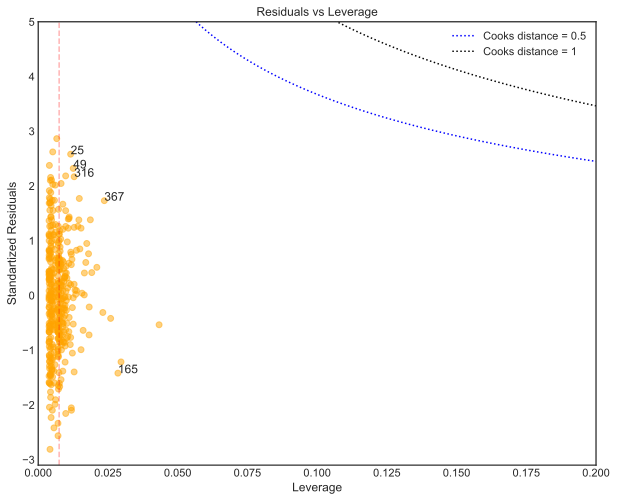

In [26]:
fig, axes = plt.subplots(1,1,figsize = (10,8))

axes.set_xlim(0, 0.2)
axes.set_ylim(-3.1, 5)
axes.set_title('Residuals vs Leverage')
axes.set_xlabel('Leverage')
axes.set_ylabel('Standartized Residuals')

for obs in top_five_cooks:
    axes.annotate(obs, xy = (leverage[obs],stud_resid[obs]))

p = len(results_small.params) - 1 # number of predictors 
n = len(df_cs) # number of observations 
axes.axvline((p+1)/n, linestyle = 'dashed', color = 'red', alpha = 0.3) # average leverage of all the observations 

# Cooks distance = 0.5 plot in the leverage vs residuals plane 
x = np.linspace(0.01,0.2,100)

def cooks_dy(l,d):
    return np.sqrt((p+1) * d * (1-l)/l)

axes.plot(x, cooks_dy(x, d = 0.5), label = 'Cooks distance = 0.5', ls = ':' , color = 'blue')
axes.plot(x, cooks_dy(x, d = 1), label = 'Cooks distance = 1', ls = ':' , color = 'black')
axes.legend(loc = 'best')

axes.scatter(leverage,stud_resid, alpha = 0.5, color = 'orange')

### No outliers becuase all the observations rest between -3 and 3 (or smaller than 3 in absolute value) in the y axis. There are some candidates for high leverage points given by the points on the far right hand side of dashed red line which indicates the average leverage of the sample. However, these points are quite far away from Cooks distance = 0.5/1. Therefore although there are candidate high leverage points they seem unlikely to influence the fit. Finally annotated points in dicates the top 5 observations that has the largest cooks distance. 

## **References**

### It turns out that in R, plotting diagnostic plots to test the performence of linear regression procedure is much easier. I followed the link below to generate plots similar to the main text for diagnosis of heteroskasdicity, outliers, leverage points and nonlinearity. 

- https://emredjan.medium.com/emulating-r-regression-plots-in-python-43741952c034

### Cooks distance: 

- https://en.wikipedia.org/wiki/Cook%27s_distance

### Introduction to Statistical Learning with Python: 

- [Introduction to Statistical Learning with Python](https://www.statlearning.com/). 